In [1]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from scipy import signal, special

Import der Audiodatei als Array

In [2]:
y, sr = sf.read("Bach.wav")

Konstanten

In [3]:
# Dimension
n = 4

# Anzahl der Channel der Sounddatei, erwartet wird 1 oder 2
channel = y.ndim

# Geschwindigkeiten alle in m/s
v = 343  # Schalllgeschwindigkeit in Luft

# Abstand Quelle und Emfänger zu Beginn in m
r = 10

Wandelt den dreidimensionalen Schalldruck in f(t) um

In [4]:
def entko(h):
    return h*4*np.pi*r

Wandelt wieder in den Druck in der entsprechenden Dimension zurück

In [5]:
def verko(h):
    if n == 1:
        return h*v/2
    if n % 2 == 0:
        return (h*(-1)**(n/2-1)*(n+1)*(np.pi)**((n-1)/2) / (
            4*(2*np.pi)**(n-1)*v**(n-2)*special.gamma((n+3)/2)))
    else:
        return (h*(-1)**((n-3)/2)*n*(np.pi)**((n-2)/2) / (
            8*(2*np.pi)**(n-2)*v**(n-3)*r*special.gamma((n+2)/2)))

Bestimmt die numerische Ableitung d-ter Ordnung

In [6]:
def abl(self, d):
    if(d > 0):
        eit = np.gradient(self, 1/sr)
        return abl(eit[1:len(eit)-1], d-1)
    else:
        return self

Faltungsfunktion

In [7]:
def falt(self, theta, d):
    if channel == 1:
        zw01 = abl(entko(self), d)  # Ableitung
        zw11 = signal.convolve(zw01, theta)  # Faltung
        zw21 = zw11[:len(zw01)]/sr
        lsg = verko(zw21)
    else:  # Wie im Mono-Fall, nur wird die Faltung auf beide Kanäle angewandt
        zw01 = abl(entko(self[:, 0]), d)
        zw02 = abl(entko(self[:, 1]), d)
        zw11 = signal.convolve(zw01, theta)
        zw12 = signal.convolve(zw02, theta)
        zw21 = zw11[:len(zw01)]/sr
        zw22 = zw12[:len(zw02)]/sr
        lsg = np.empty([len(zw21), 2])
        lsg[:, 0] = verko(zw21)
        lsg[:, 1] = verko(zw22)
    return lsg

Effektivwert

In [8]:
def effw(self):
    return np.sqrt(np.mean(np.square(self)))

### Dimensionenabhängige Fälle

In [9]:
if n == 1:
    # Erstellt den zu f(t) zugehörigen Faltungskern für n=1
    theta = np.ones(len(y)*2)
    lsg = falt(y, theta, 0)

    # Gleitende Mittelung des Arrays
    f = 5000  # Länge der Intervalle in die die Datei aufgeteilt wird
    h = int(len(y)/f)  # Anzahl an Intervallen in die die Datei aufgeteilt wird
    gleitwert = 2  # Anzahl an Zwischenintervallen in
    #  denen zusätzlich gemittelt wird
    if len(y) % f != 0:
        h += 1  # Rundet h auf, falls das Array nicht
        # vollständig abgedeckt wird
    if channel == 1:
        for i in range(0, h):
            for j in range(1, gleitwert+1):
                if int((i+1/j-1)*f) > 0:
                    lsg[int((i+1/j-1)*f):int((i+1/j)*f)
                        ] -= np.mean(lsg[int((i+1/j-1)*f):int((i+1/j)*f)])
                else:
                    lsg[0:int((i+1/j)*f)] -= np.mean(lsg[0:int((i+1/j)*f)])
    else:
        for i in range(0, h):
            for j in range(1, gleitwert+1):
                if int((i+1/j-1)*f) > 0:
                    lsg[int((i+1/j-1)*f):int((i+1/j)*f),
                        0] -= np.mean(lsg[int((i+1/j-1)*f):int((i+1/j)*f), 0])
                    lsg[int((i+1/j-1)*f):int((i+1/j)*f),
                        1] -= np.mean(lsg[int((i+1/j-1)*f):int((i+1/j)*f), 1])
                else:
                    lsg[0:int((i+1/j)*f), 0] -= np.mean(
                        lsg[0:int((i+1/j)*f), 0])
                    lsg[0:int((i+1/j)*f), 1] -= np.mean(
                        lsg[0:int((i+1/j)*f), 1])

In [10]:
if n % 2 == 0:
    # Erstellt den zu f(t) zugehörige Faltungskern für n%2=0
    theta = np.empty([len(y)])
    for i in range(0, len(theta)):
        theta[i] = (i+1/2)/sr*((i+1/2)/sr+2*r/v)
        # T wird um 1/2 Indizes verschoben um die Singularität bei 0 zu umgehen
    theta = 1/np.sqrt(theta)
    lsg = falt(y, theta, n-2)

In [11]:
if n == 3:
    lsg = y

In [12]:
if n % 2 != 0 and n > 3:
    if channel == 1:
        lsg = verko(abl(entko(y), n-3))

    else:
        if channel == 2:
            zw11 = abl(entko(y[:, 0]), n-3)
            zw12 = abl(entko(y[:, 1]), n-3)
            lsg = np.empty([len(zw11), 2])
            lsg[:, 0] = verko(zw11)
            lsg[:, 1] = verko(zw12)

Exportiert und normiert die resultierende Lösung

In [13]:
norm = lsg/np.absolute(lsg).max()*0.99  # Normalisiert die Lösung
sf.write('4d.wav', norm, sr)  # Erstellt eine neue Audiodatei im Ordner

Plot der Lösung

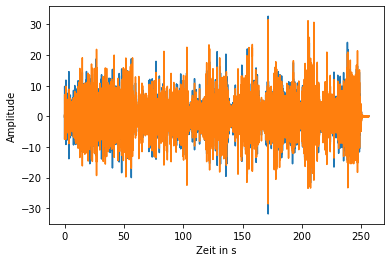

In [14]:
t = np.arange(0, len(lsg)/sr, 1/sr)
plt.plot(t, lsg)  
plt.xlabel('Zeit in s')
plt.ylabel('Amplitude')
plt.show()  

Plot der ursprünglichen Datei

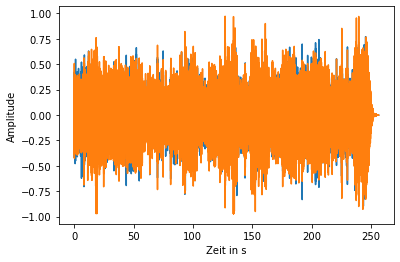

In [15]:
t = np.arange(0, len(y)/sr, 1/sr)
plt.plot(t, y)  
plt.xlabel('Zeit in s')
plt.ylabel('Amplitude')
plt.show()  

Differenz der Schalldruckpegel in dB

In [16]:
print(20*np.log10(effw(lsg)/effw(y)))

22.64053884352765
